
# Cohort Analysis in SQLite

This notebook shows you how to do Cohort Analysis in SQLite. It will follow the same steps as the first chapter of the DataCamp course [Customer Segmentation](https://www.datacamp.com/courses/customer-segmentation-in-python/). As working with SQLite doesn't require any configuration to get started, we will use this as our database. The Cohort Analysis will be done fully in SQL, although some parts will be done in Python (import into SQlite, some long queries & the final visualization).

Note : If you have never worked with notebooks or SQL in notebooks before, it is recommended that you first go through this [Introduction to DataCamp Projects](https://www.datacamp.com/projects/571). Documentation on how to use SQL in notebooks can be found [here](https://github.com/catherinedevlin/ipython-sql) and on the SQLite syntax [here](http://www.sqlitetutorial.net). 



## 0. Create SQLite database (Python)

We will use the same data set as was used in the DataCamp course : the [Online Retail data set](http://archive.ics.uci.edu/ml/datasets/Online+Retail) from the UCI Machine Learning Repository. We will import this dataset, which comes in the form of an Excel file, into a SQLite database. As SQL champs we will write some extensive queries, and as notebooks don't support multiline queries, we will write a function that executes a query and returns the results. This function will be used to execute all queries for this project, but don't worry, you will only have to complete the SQL parts.


In [2]:
## -- Just run this cell -- ##
# It will run a few lines of Python to create our database

# Import library
import pandas as pd
import sqlite3 as lite

# Import Excel file
df = pd.read_excel('Online Retail.xlsx')
df.info()

# Create SQLite database & connection
con = lite.connect('OnlineRetail.db')

# Load into SQLite database 
df.to_sql('dataset', con, if_exists='replace', index=False)


In [13]:
## -- Just run this cell -- ##
# It will execute a query and return the number of rows in our dataset

# Create function that executes query
def ExecuteQuery(query, con):
    """ Function to execute query & return results"""
    # Create cursor
    cur = con.cursor()
    # Execute query
    cur.execute(query)
    # Capture returned data
    data = cur.fetchall()
    # Close cursor
    cur.close()
    # Return data
    return data
    
# Run test query
ExecuteQuery('select count(*) from dataset;', con)
    

[(541909,)]


## 1. Create connection & inspect data 

The dataset contains 8 columns and over 0.5 million records. The full dataset has been imported for you into the 'dataset' table. As a starter, can you calculate the exact number of unique customers in this dataset?


In [14]:
# For the remainder of the project, cells will look like this one
# You will have to complete the query. The part that executes it, will always be written for you.

## -- TASK 1 -- ## 
# Can you show the first 10 rows from our dataset?
query = """
    select * 
    from dataset 
    limit 10;
"""

# Execute query
ExecuteQuery(query, con)


[('536365',
  '85123A',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  6,
  '2010-12-01 08:26:00',
  2.55,
  17850.0,
  'United Kingdom'),
 ('536365',
  '71053',
  'WHITE METAL LANTERN',
  6,
  '2010-12-01 08:26:00',
  3.39,
  17850.0,
  'United Kingdom'),
 ('536365',
  '84406B',
  'CREAM CUPID HEARTS COAT HANGER',
  8,
  '2010-12-01 08:26:00',
  2.75,
  17850.0,
  'United Kingdom'),
 ('536365',
  '84029G',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  6,
  '2010-12-01 08:26:00',
  3.39,
  17850.0,
  'United Kingdom'),
 ('536365',
  '84029E',
  'RED WOOLLY HOTTIE WHITE HEART.',
  6,
  '2010-12-01 08:26:00',
  3.39,
  17850.0,
  'United Kingdom'),
 ('536365',
  '22752',
  'SET 7 BABUSHKA NESTING BOXES',
  2,
  '2010-12-01 08:26:00',
  7.65,
  17850.0,
  'United Kingdom'),
 ('536365',
  '21730',
  'GLASS STAR FROSTED T-LIGHT HOLDER',
  6,
  '2010-12-01 08:26:00',
  4.25,
  17850.0,
  'United Kingdom'),
 ('536366',
  '22633',
  'HAND WARMER UNION JACK',
  6,
  '2010-12-01 08:28:00',
  1.85,
  178

In [15]:
# From now on, always use "%sql" at the start of a query
# For example, the line below shows how to query the number of unique countries in the dataset
query = """
    select count(distinct Country) as UniqueCountries 
    from dataset;
"""

# Execute query
ExecuteQuery(query, con)


[(38,)]

In [7]:
# Can you find the number of unique customers in the dataset?
## -- TASK 1 -- ## 
%sql select count(distinct CustomerID) as UniqueCustomers from dataset;


 * sqlite:///OnlineRetail.db
Done.


UniqueCustomers
4372



## 2. Get the relevant data

This dataset contains invoice data by product. This means the columns InvoiceDate, CustomerID and Country contain a lot of duplicate data, as they are repeated for every product of the same invoice. As we only need the columns InvoiceDate and CustomerID for Cohort Analysis, can you create a new table named 'online' which only contains the data we are interested in?


In [8]:
# Query below will delete the table if it exists already (in case you have to run this cell multiple times)
%sql drop table if exists online;

# Can you create a new table 'online' with the unique values of columns CustomerID and InvoiceDate?
## -- TASK 2 -- ## 
%sql create table online as select distinct CustomerID, InvoiceDate from dataset where CustomerID is not null;

# View data of new table
%sql select * from online order by CustomerID, InvoiceDate limit 10;


 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.


CustomerID,InvoiceDate
12346.0,2011-01-18 10:01:00
12346.0,2011-01-18 10:17:00
12347.0,2010-12-07 14:57:00
12347.0,2011-01-26 14:30:00
12347.0,2011-04-07 10:43:00
12347.0,2011-06-09 13:01:00
12347.0,2011-08-02 08:48:00
12347.0,2011-10-31 12:25:00
12347.0,2011-12-07 15:52:00
12348.0,2010-12-16 19:09:00



## 3. Calculate Cohort Month by Customer

As in the Customer Segmentation course, we first have to find the first month by customer, which we will call CohortMonth. Can you create a new table which contains the minimum InvoiceDate by CustomerID?


In [9]:
# Query below will delete the table if it exists already (in case you have to run this cell multiple times)
%sql drop table if exists cohortmonth;

# Can you create a new table 'cohortmonth' in the database containing the first month by customer?
## -- TASK 3 -- ## 
%sql create table cohortmonth as select CustomerID, min(InvoiceDate) as CohortMonth from online group by CustomerID;

# View data of new table
%sql select * from cohortmonth order by CustomerID limit 10;


 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.


CustomerID,CohortMonth
12346.0,2011-01-18 10:01:00
12347.0,2010-12-07 14:57:00
12348.0,2010-12-16 19:09:00
12349.0,2011-11-21 09:51:00
12350.0,2011-02-02 16:01:00
12352.0,2011-02-16 12:33:00
12353.0,2011-05-19 17:47:00
12354.0,2011-04-21 13:11:00
12355.0,2011-05-09 13:49:00
12356.0,2011-01-18 09:50:00



## 4. Join data together

Can you create a new table which combines the two tables online and cohortmonth?


In [10]:
# Drop table statement (in case you have to run this cell multiple times)
%sql drop table if exists onlinecohort;

# Can you create a new table 'onlinecohort' by joining the new table to the online table?
## -- TASK 4 -- ## 
%sql create table onlinecohort as select distinct o.CustomerID, date(o.InvoiceDate, 'start of month') as InvoiceDate, date(m.CohortMonth, 'start of month') as CohortMonth from online o join cohortmonth m on o.CustomerID = m.CustomerID;

# View data of new table
%sql select * from onlinecohort order by CustomerID limit 10;


 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.


CustomerID,InvoiceDate,CohortMonth
12346.0,2011-01-01,2011-01-01
12347.0,2010-12-01,2010-12-01
12347.0,2011-01-01,2010-12-01
12347.0,2011-04-01,2010-12-01
12347.0,2011-06-01,2010-12-01
12347.0,2011-08-01,2010-12-01
12347.0,2011-10-01,2010-12-01
12347.0,2011-12-01,2010-12-01
12348.0,2010-12-01,2010-12-01
12348.0,2011-01-01,2010-12-01



## 5. Calculate Cohort Index

By using this new table, we can now calculate the Cohort Index, defined as the difference in months between the InvoiceDate and the CohortMonth + 1. We add this extra month so the Cohort Month has the value of 1. Can you calculate the Cohort Index?


In [11]:
# Drop table statement (in case you have to run this cell multiple times)
%sql drop table if exists cohortindex;

# Can you create a new table 'cohortindex' by calculating the Cohort Index?
# In SQLite, we have to calculate the difference in days in this way: "julianday(day1)-julianday(day2)"
## -- TASK 5 -- ## 
%sql create table cohortindex as SELECT o.*, cast((julianday(o.InvoiceDate) - julianday(o.CohortMonth)) as integer)/30 + 1 as CohortIndex from onlinecohort o;

# View data of new table
%sql select * from cohortindex order by CustomerID, InvoiceDate limit 10;


 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.


CustomerID,InvoiceDate,CohortMonth,CohortIndex
12346.0,2011-01-01,2011-01-01,1
12347.0,2010-12-01,2010-12-01,1
12347.0,2011-01-01,2010-12-01,2
12347.0,2011-04-01,2010-12-01,5
12347.0,2011-06-01,2010-12-01,7
12347.0,2011-08-01,2010-12-01,9
12347.0,2011-10-01,2010-12-01,11
12347.0,2011-12-01,2010-12-01,13
12348.0,2010-12-01,2010-12-01,1
12348.0,2011-01-01,2010-12-01,2



## 6. Count unique customers

Can you calculate the number of unique customers by CohortMonth and CohortIndex?


In [12]:
# Drop table statement (in case you have to run this cell multiple times)
%sql drop table if exists pivotdata;

# Can you create a new table 'pivotdata' containing the number of unique customers?
## -- TASK 6 -- ## 
%sql create table pivotdata as SELECT CohortMonth, CohortIndex, count(distinct CustomerID) 'Customers' from cohortindex group by CohortMonth, CohortIndex;

# View data of new table
%sql select * from pivotdata order by 1,2 limit 10;


 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.
 * sqlite:///OnlineRetail.db
Done.


CohortMonth,CohortIndex,Customers
2010-12-01,1,948
2010-12-01,2,362
2010-12-01,3,317
2010-12-01,4,367
2010-12-01,5,341
2010-12-01,6,376
2010-12-01,7,360
2010-12-01,8,336
2010-12-01,9,336
2010-12-01,10,374



## 7. Create pivot table

Great! Can you make a pivot table out of it?


In [13]:
# Note: Here I realize SQLite doesn't have a pivot function. The query below was used to create the pivot table:

# Drop table statement (in case you have to run this cell multiple times)
ExecuteQuery('drop table if exists pivot;', con)

# Query to create pivot table
pivot_query = """
create table pivot as
select distinct p.CohortMonth,
p1.Customers as 'Index1',
p2.Customers as 'Index2',
p3.Customers as 'Index3',
p4.Customers as 'Index4',
p5.Customers as 'Index5',
p6.Customers as 'Index6',
p7.Customers as 'Index7',
p8.Customers as 'Index8',
p9.Customers as 'Index9',
p10.Customers as 'Index10',
p11.Customers as 'Index11',
p12.Customers as 'Index12',
p13.Customers as 'Index13'
from pivotdata p
left join pivotdata p1 on p1.CohortMonth = p.CohortMonth and p1.CohortIndex = 1
left join pivotdata p2 on p2.CohortMonth = p.CohortMonth and p2.CohortIndex = 2
left join pivotdata p3 on p3.CohortMonth = p.CohortMonth and p3.CohortIndex = 3
left join pivotdata p4 on p4.CohortMonth = p.CohortMonth and p4.CohortIndex = 4
left join pivotdata p5 on p5.CohortMonth = p.CohortMonth and p5.CohortIndex = 5
left join pivotdata p6 on p6.CohortMonth = p.CohortMonth and p6.CohortIndex = 6
left join pivotdata p7 on p7.CohortMonth = p.CohortMonth and p7.CohortIndex = 7
left join pivotdata p8 on p8.CohortMonth = p.CohortMonth and p8.CohortIndex = 8
left join pivotdata p9 on p9.CohortMonth = p.CohortMonth and p9.CohortIndex = 9
left join pivotdata p10 on p10.CohortMonth = p.CohortMonth and p10.CohortIndex = 10
left join pivotdata p11 on p11.CohortMonth = p.CohortMonth and p11.CohortIndex = 11
left join pivotdata p12 on p12.CohortMonth = p.CohortMonth and p12.CohortIndex = 12
left join pivotdata p13 on p13.CohortMonth = p.CohortMonth and p13.CohortIndex = 13
order by 1;
"""

# Execute
ExecuteQuery(pivot_query, con)


[]

In [14]:
# View pivot table data
%sql select * from pivot;


 * sqlite:///OnlineRetail.db
Done.


CohortMonth,Index1,Index2,Index3,Index4,Index5,Index6,Index7,Index8,Index9,Index10,Index11,Index12,Index13
2010-12-01,948,362,317,367,341,376,360,336,336,374,354,474,260
2011-01-01,421,171,None,102,138,126,110,108,131,146,155,63,None
2011-02-01,380,73,106,None,102,94,97,107,98,119,35,None,None
2011-03-01,440,84,112,96,102,78,116,105,127,39,None,None,None
2011-04-01,299,68,66,63,62,71,69,78,25,None,None,None,None
2011-05-01,279,66,48,48,60,68,74,29,None,None,None,None,None
2011-06-01,235,49,44,64,58,79,24,None,None,None,None,None,None
2011-07-01,191,40,39,44,52,22,None,None,None,None,None,None,None
2011-08-01,167,42,42,42,23,None,None,None,None,None,None,None,None
2011-09-01,298,89,97,36,None,None,None,None,None,None,None,None,None



## 8. Create retention rate table

Awesome! Can you create a retention table of the pivot table?


In [15]:
# Note: Notebooks only allow single line queries, so the query below was used to create the retention table:

# Drop table statement (in case you have to run this cell multiple times)
ExecuteQuery('drop table if exists retention;', con)

# Query to create retention table
retention_query = """
create table retention as
select CohortMonth,
round((Index1+0.0)/Index1,5)as 'Index1',
round((Index2+0.0)/Index1,5)as 'Index2',
round((Index3+0.0)/Index1,5)as 'Index3',
round((Index4+0.0)/Index1,5)as 'Index4',
round((Index5+0.0)/Index1,5)as 'Index5',
round((Index6+0.0)/Index1,5)as 'Index6',
round((Index7+0.0)/Index1,5)as 'Index7',
round((Index8+0.0)/Index1,5)as 'Index8',
round((Index9+0.0)/Index1,5)as 'Index9',
round((Index10+0.0)/Index1,5)as 'Index10',
round((Index11+0.0)/Index1,5)as 'Index11',
round((Index12+0.0)/Index1,5)as 'Index12',
round((Index13+0.0)/Index1,5)as 'Index13'
from pivot;
"""

# Execute
ExecuteQuery(retention_query, con)


[]

In [16]:
# View pivot table data
%sql select * from retention;


 * sqlite:///OnlineRetail.db
Done.


CohortMonth,Index1,Index2,Index3,Index4,Index5,Index6,Index7,Index8,Index9,Index10,Index11,Index12,Index13
2010-12-01,1.0,0.38186,0.33439,0.38713,0.3597,0.39662,0.37975,0.35443,0.35443,0.39451,0.37342,0.5,0.27426
2011-01-01,1.0,0.40618,None,0.24228,0.32779,0.29929,0.26128,0.25653,0.31116,0.34679,0.36817,0.14964,None
2011-02-01,1.0,0.19211,0.27895,None,0.26842,0.24737,0.25526,0.28158,0.25789,0.31316,0.09211,None,None
2011-03-01,1.0,0.19091,0.25455,0.21818,0.23182,0.17727,0.26364,0.23864,0.28864,0.08864,None,None,None
2011-04-01,1.0,0.22742,0.22074,0.2107,0.20736,0.23746,0.23077,0.26087,0.08361,None,None,None,None
2011-05-01,1.0,0.23656,0.17204,0.17204,0.21505,0.24373,0.26523,0.10394,None,None,None,None,None
2011-06-01,1.0,0.20851,0.18723,0.27234,0.24681,0.33617,0.10213,None,None,None,None,None,None
2011-07-01,1.0,0.20942,0.20419,0.23037,0.27225,0.11518,None,None,None,None,None,None,None
2011-08-01,1.0,0.2515,0.2515,0.2515,0.13772,None,None,None,None,None,None,None,None
2011-09-01,1.0,0.29866,0.3255,0.12081,None,None,None,None,None,None,None,None,None



## 9. Visualize retention rates with heatmap

As a final step, we will visualize the retention rates with Seaborn. Can you fill in the missing gaps?


 * sqlite:///OnlineRetail.db
Done.
Returning data to local variable retention


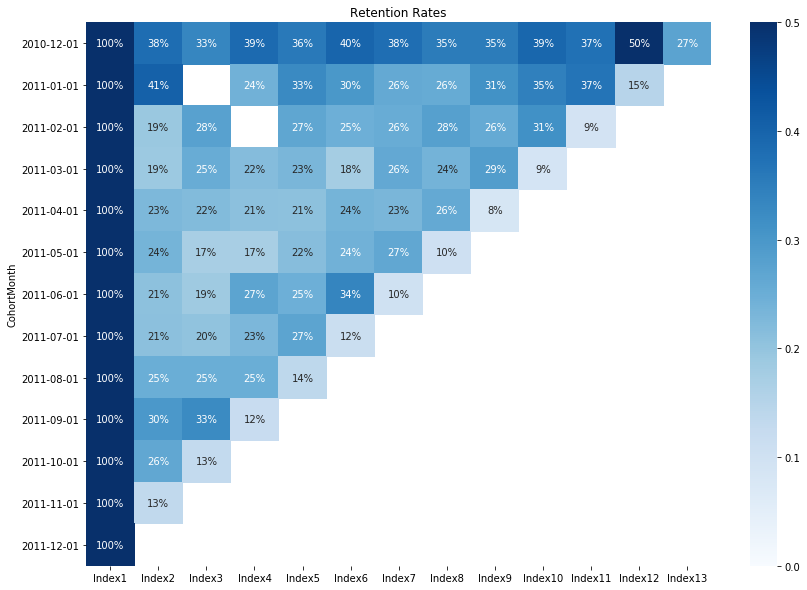

In [17]:
# Get data in variable
%sql retention << select * from retention;

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Get data into Pandas DataFrame
df = pd.DataFrame(retention, columns=['CohortMonth','Index1','Index2','Index3','Index4','Index5',
                                      'Index6','Index7','Index8','Index9','Index10','Index11','Index12','Index13']
                 )
df.set_index('CohortMonth', inplace=True)

%matplotlib inline
# Create heatmap
## -- TASK 6 -- ## 
plt.figure(figsize=(14, 10))
plt.title('Retention Rates')
sns.heatmap(df, annot=True, fmt='.0%', vmin=0, vmax=0.5, cmap='Blues') 
plt.show()


In [18]:
# Congratulations! Now you know how to do Cohort Analyses in SQL!

# Run below query to close the connection to the database
#con.close()